In [2]:
import numpy as np
from PIL import Image, ImageDraw
import cv2

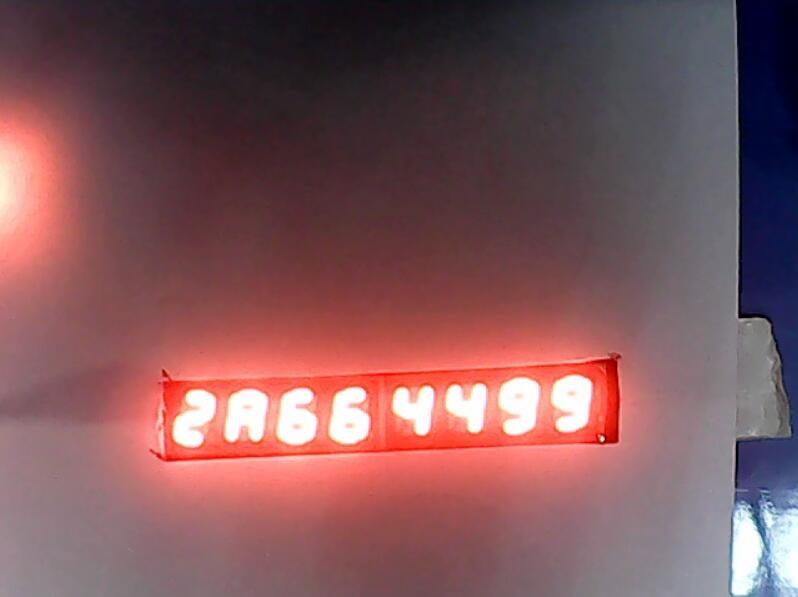

In [28]:
i='20'
img_path=f'test_imgs/raw_{i}.jpg'
Image.open(img_path)

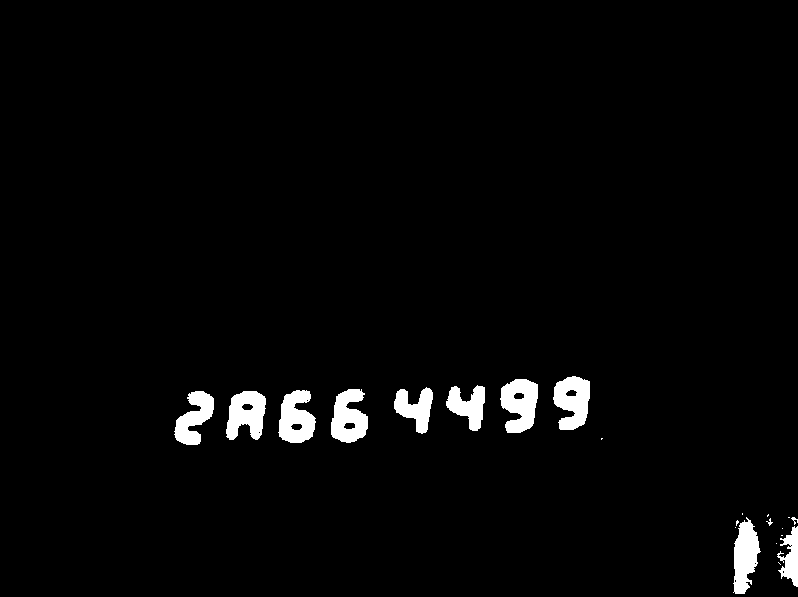

In [29]:
# 二值化
raw = cv2.imread(img_path,0)
ret, mask = cv2.threshold(raw,max(map(max,np.array(raw)))-10,255,cv2.THRESH_BINARY)
Image.fromarray(mask)

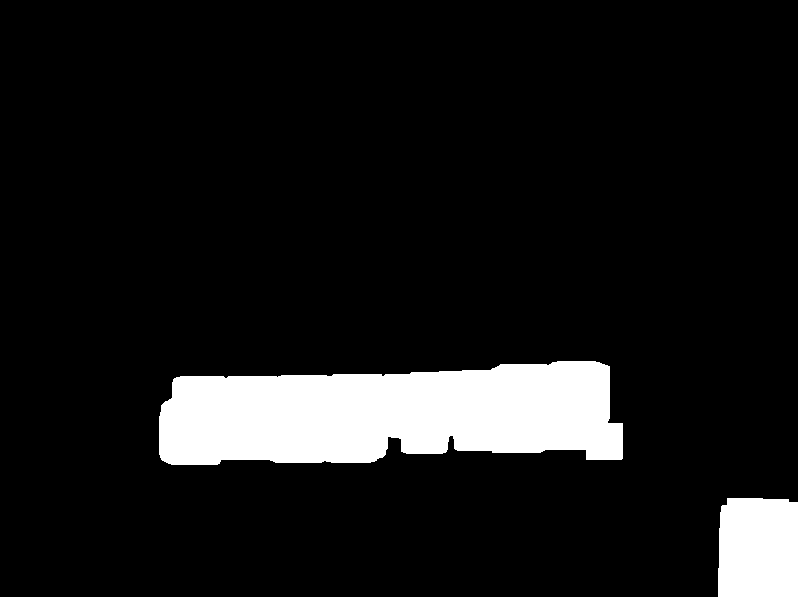

In [30]:
dilate = cv2.dilate(mask,np.ones((8,8),np.uint8),iterations=5)
Image.fromarray(dilate)

[7526.5, 38195.0]
1
<class 'list'> 2


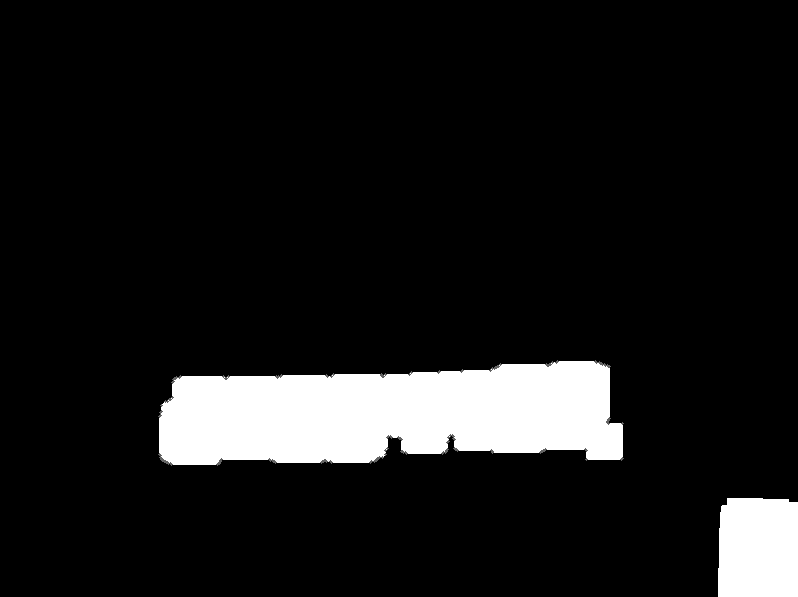

In [31]:
contours, hierarchy = cv2.findContours(dilate,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
ls=list(map(lambda x:cv2.contourArea(x),contours))
print(ls)
max_id=np.argmax(ls)
max_con= contours[max_id]
print(max_id)
print(type(contours),len(contours))
cv2.drawContours(dilate,max_con,-1,(100),2) 
Image.fromarray(dilate)

(597, 798)
(103, 463)


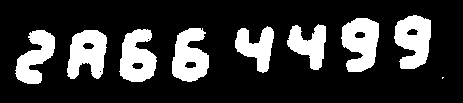

In [33]:
max_con=max_con.reshape(-1,2)
col=max_con[:,0]
row=max_con[:,1]
print(mask.shape)
digit_area=mask[min(row):max(row), min(col):max(col)]
print(digit_area.shape)
Image.fromarray(digit_area)

In [34]:
# 获取白色像素的坐标
coords = np.column_stack(np.where(digit_area > 0))
print(coords)
# 计算旋转角度
angle = cv2.minAreaRect(coords)[-1]
if angle < -45:
    angle = -(90+ angle)
else:
    angle = -angle
print(angle)

[[ 15 413]
 [ 15 414]
 [ 15 415]
 ...
 [ 83  36]
 [ 83  37]
 [ 83  38]]
-0.7090606689453125


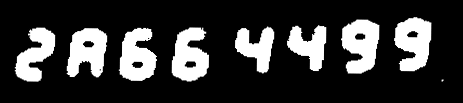

In [35]:
h, w = digit_area.shape[:2]
center = (w//2, h//2)
# 获取旋转矩阵
M = cv2.getRotationMatrix2D(center, angle, 1.0)
# 旋转
rotated = cv2.warpAffine(digit_area, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

Image.fromarray(rotated)

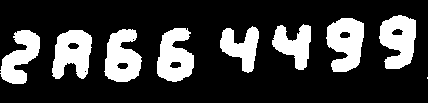

In [36]:
# 去除左右两边的黑色
white_col = np.argwhere(digit_area == 255)[:,1]
digit_area=digit_area[:,min(white_col):max(white_col)]
Image.fromarray(digit_area)

In [15]:
# 单个图像的宽度为数字区域宽度的八分之一
w=round(digit_area.shape[1]/8)
# 存放8个数字
digits=[]
# 黑色背景
bg=np.zeros((64,48),dtype=np.uint8)
for i in range(8):
    d=digit_area[:,i*w:(i+1)*w]
#     去除上下两边的黑色
    white_row=np.argwhere(d==255)[:,0]
    d=d[min(white_row):max(white_row),:]
#     等比例缩放为宽度为48的图片
    d=cv2.resize(d,(48,d.shape[0]*48//d.shape[1]))

    _=bg.copy()
#     若单个数字的高度超过64，则取中间的64个像素;否则将其贴在背景的中央
    if d.shape[0]>=64:
        _=d[(d.shape[0]-64)//2:(d.shape[0]-64)//2+64,:]
    else:
        _[31-d.shape[0]//2:31-d.shape[0]//2+d.shape[0],0:48]=d
    digits.append(_)

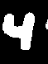

In [38]:
Image.fromarray(digits[4])

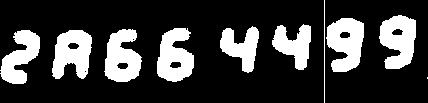

In [41]:
# 测试 单个数字的切割线
tmp=digit_area.copy()
w=round(tmp.shape[1]/8)
i=6
Image.fromarray(cv2.line(tmp,(i*w,0),(i*w,tmp.shape[0]),(255)))